# Validation of 2nd-NLEIS

The validation of 2nd-NLEIS experiments is a mult-step process that ensures the weakly nonlinearity, stationarity, and causality of the system. Here, we considered a galvanostatic meaasurement. 

The first step is to verify the weakly nonlinearity by evaluating the total harmonic distortion (THD). Through the THD analysis, it is important to maintain consistently low THD in the current perturbation, while ensuring that the voltage response THD remains below 1%. Data truncation can be performed in this step by eliminating any data that has a spike in the current THD, which indicate that higher harmonic signals are not solely generated by the system, thereby violating the assumption of 2nd-NLEIS. This usually happens at high frequency where 2nd-NLEIS spectra converge to origin and hence can be ignored for data analysis without losing any information. 

The stationarity and causality requirement can then be verified through the evaluation of Kramers–Kronig (KK)relations, which is numerically challenging. Fortunately, LinKK test has been developed for EIS and we have also developed a measurement model test for 2nd-NLEIS to evaluate the satisfication of KK-relations. The success regression of LinKK and measurement model test is then indicates the satisfication of KK-relations, and hence stationarity and causality.

The following example will detailed the workflow for this validation process.

## Step 1: Load the data

Here we adopted a wholecell pouch cell data collected at 3.5 V using Autolab Potentiaostat. The data can be loaded directly with the `data_loader()` function. It is also important to set **`max_k = 10`**, so that the first 10 harmonic signal will be reported for the THD analysis.

In [1]:
from nleis.data_processing import data_loader
filename = 'example_data.txt'
data = data_loader(filename, equipment='autolab', fft='scipy', max_k=10,
                multi_current=False, rtol=5e-4, phase_correction=True,
                baseline=True)
freq = data[0]
Z1 = data[1]
Z2 = data[2]

## Step 2: THD Analysis

The loaded data contains a dataframe of harmonic signal for both current and voltage. It can be easily analyzed by the `thd()` function provided, which returns the frequency dependent thd for current and voltage.

In [2]:
from nleis.data_processing import thd

In [3]:
I_thd, V_thd = thd(data[-1])

The results can then be visualized using `matplotlib`.

In [4]:
import string
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

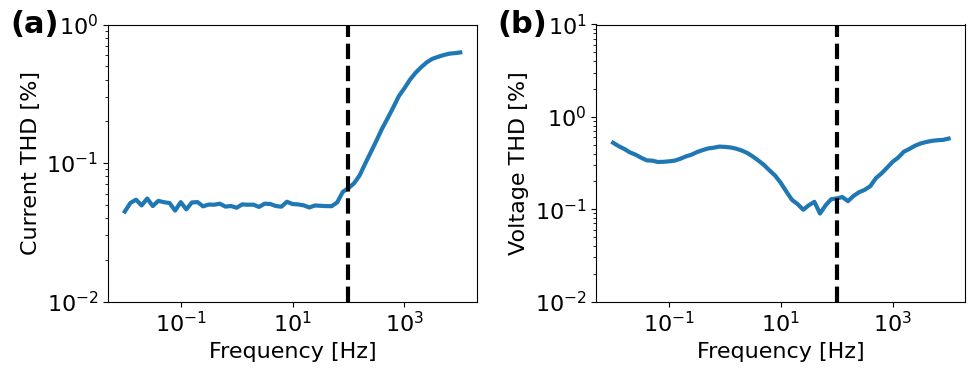

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
for idx, axi in enumerate(ax.flat):    
    axi.text(-0.2, 1, f'({string.ascii_lowercase[idx]})',horizontalalignment='center',verticalalignment='center', transform=axi.transAxes, size=22, weight='bold')

ax[0].loglog(freq,I_thd*100, lw = 3)
ax[0].axvline(x=100, color='black', linestyle='--', lw =3 )
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Current THD [%]')
ax[0].set_ylim([1e-2,1])

ax[1].loglog(freq,V_thd*100, lw = 3)
ax[1].axvline(x=100, color='black', linestyle='--', lw =3 )

ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Voltage THD [%]')
ax[1].set_ylim([1e-2,10])

plt.tight_layout()
plt.show()

As shown by the THD results, the current perturbation maintains a stable THD for frequencies below 100 Hz (as indicated by the dashed line), after which the THD spikes. Similarly, the voltage THD reaches its minimum around 100 Hz, suggesting a converging behavior due to internal nonlinearity. These findings indicate that the signal should be truncated at approximately 100 Hz to ensure the validity of the weakly nonlinear condition and confirm that the observed nonlinear behavior is solely driven by the system’s intrinsic nonlinearity.

Therefore, full spectrum EIS will be analyzed, while 2nd-NLEIS will be analyzed for upto 100 Hz.

## Step 3: LinKK Test for EIS

The LinKK test is available in `impedance.py` as `linKK()`, providing an automated workflow for performing the LinKK test. For a detailed explanation, please refer to the [official documentation](https://impedancepy.readthedocs.io/en/latest/examples/validation_example.html). This tutorial will focus on an example implementation.

In [6]:
from impedance.validation import linKK
M, mu, Z_linKK, res_real, res_imag = linKK(freq, Z1, c=0.85, max_M=100, fit_type='complex', add_cap=True)

10 1.0 0.0019913195270216256
20 1.0 0.0011229431923891814


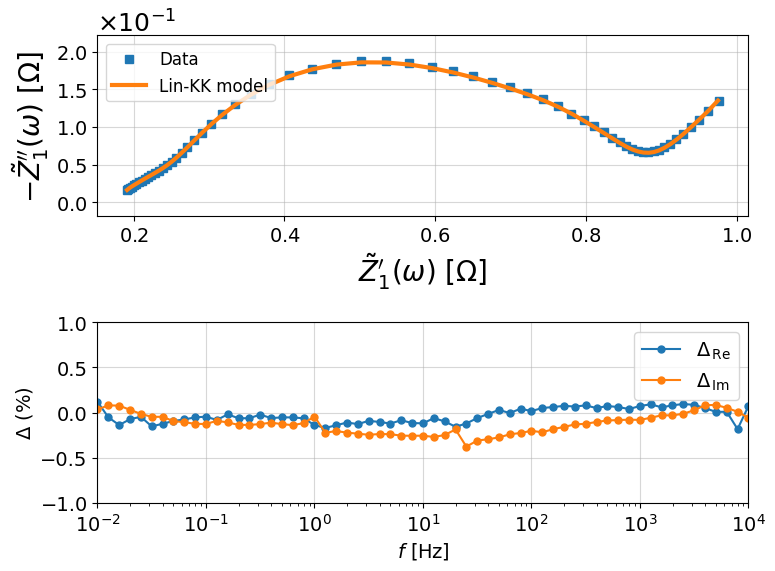

In [7]:
from impedance.visualization import plot_residuals
from nleis.visualization import plot_first

fig,ax = plt.subplots(2,1,figsize=(8,6))

# plot original data
plot_first(ax[0], Z1, fmt='s')

# plot measurement model
plot_first(ax[0], Z_linKK, fmt='-', lw =3)

ax[0].legend(['Data', 'Lin-KK model'], loc=2, fontsize=12)

# Plot residuals
plot_residuals(ax[1], freq, res_real, res_imag, y_limits=(-1,1), ms = 10)

plt.tight_layout()
plt.show()

The successful regression of LinKK test with less than 1% residual indicates the statisfication of KK-relations, hence the stationarity and causality of EIS signal.

## Step 4: Measurement Model Test for 2nd-NLEIS

The measurement model test is available in `nleis.py` as `MM()`. It offers various options, but in this example, we will focus on the cost method (`method = cost`) for a controllable implementation.

Before performing the test, the 2nd-NLEIS data need to be truncated based on the THD results and corrected for any instrument offset determined through THD analysis. In this example, the instrument offset is 0.00485745 Ω/A, which should be subtracted when inputting the impedance values.

To truncate data at 100 Hz, we can set `max_f = 100`. We can also set `plot = True` to visualize the fitting result for each iteration. 

By default, the raw_circuit is set to "Kn", representing the weakly nonlinear Randles circuit. Other tunable parameters for the `MM()` function are described in the documentation for more details.

  0%|          | 0/20 [00:00<?, ?it/s]

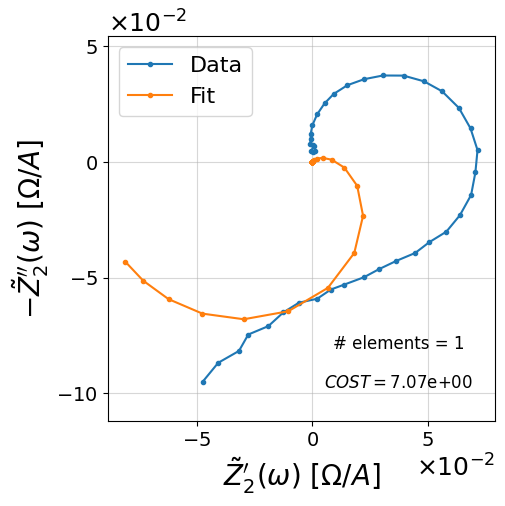

  5%|▌         | 1/20 [00:00<00:02,  6.37it/s]

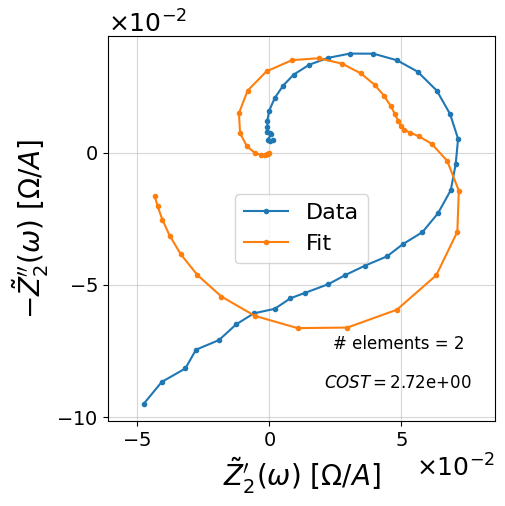

 10%|█         | 2/20 [00:00<00:03,  5.90it/s]

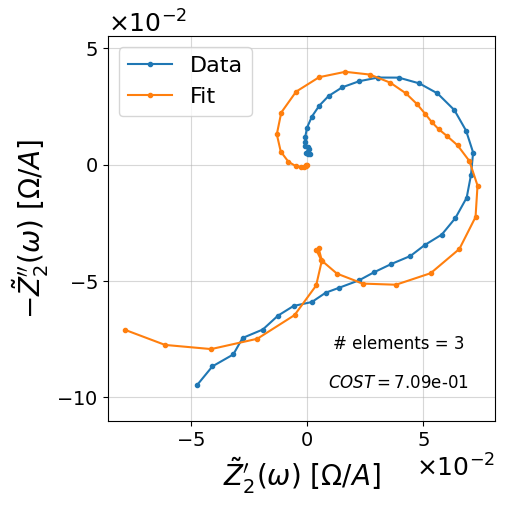

 15%|█▌        | 3/20 [00:00<00:02,  5.79it/s]

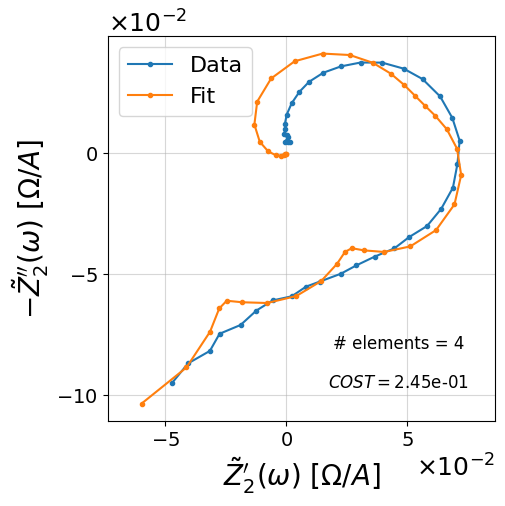

 20%|██        | 4/20 [00:00<00:02,  5.60it/s]

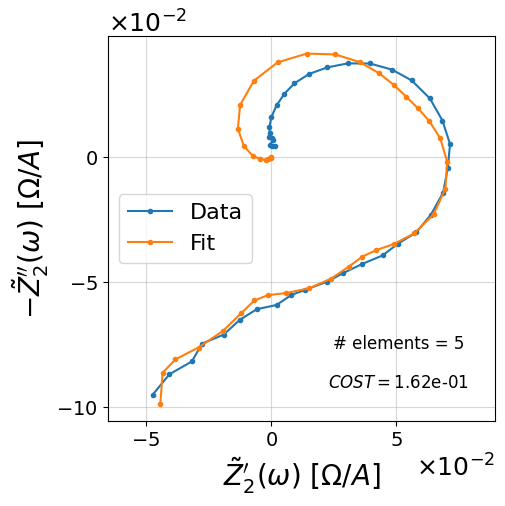

 25%|██▌       | 5/20 [00:00<00:02,  5.36it/s]

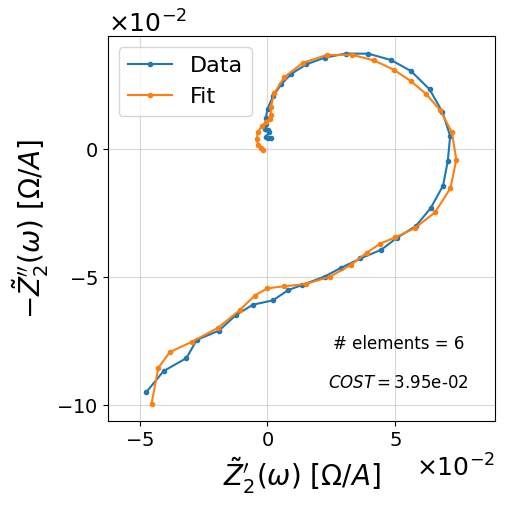

 30%|███       | 6/20 [00:01<00:02,  5.12it/s]

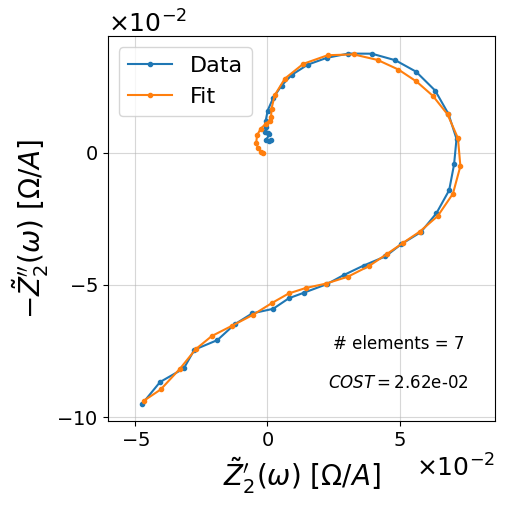

 35%|███▌      | 7/20 [00:01<00:03,  4.24it/s]

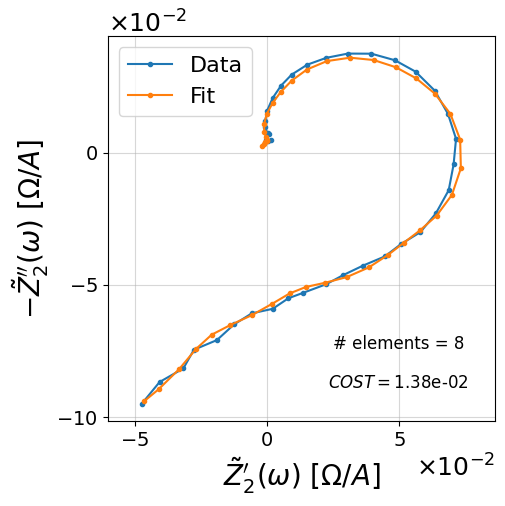

 40%|████      | 8/20 [00:01<00:03,  3.71it/s]

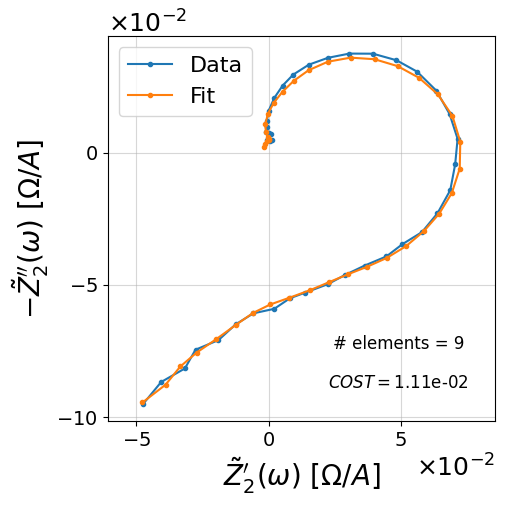

100%|██████████| 9/9 [00:32<00:00,  3.59s/it] 

Optimal solution found with M = 9


In [8]:
from nleis.validation import MM
offset = 0.00485745
results_cost = MM(freq,Z2-offset,raw_circuit='Kn',initial_guess = [0.001,0.1], method = 'cost', max_f = 100,
                    max_M = 20, tol = 5e-4,k =2, plot=True,CI_plot=False)

We can use `matplotlib` to visualize the test results again. The fitting results can be extracted as the follows 

In [9]:
Z2_MM = results_cost[3]
res_real_MM = results_cost[4]
res_imag_MM = results_cost[5]

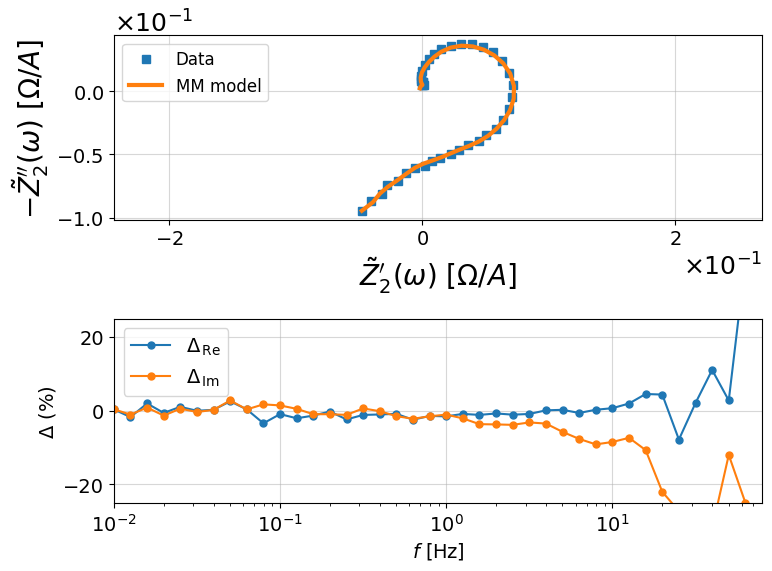

In [10]:
from nleis.visualization import plot_second

mask = freq < 100

fig,ax = plt.subplots(2,1,figsize=(8,6))

# plot original data
plot_second(ax[0], Z2[mask]-offset, fmt='s')

# plot measurement model
plot_second(ax[0], Z2_MM, fmt='-', lw =3)

ax[0].legend(['Data', 'MM model'], loc=2, fontsize=12)

# Plot residuals
plot_residuals(ax[1], freq[mask], res_real_MM, res_imag_MM, y_limits=(-25,25), ms = 10)

plt.tight_layout()
plt.show()

As observed from the fitting results, 2nd-NLEIS generally exhibits larger residual errors, primarily due to its relatively small signal compared to EIS. Consequently, a residual error of less than 10% is considered acceptable for 2nd-NLEIS.

In this example, a diverging residual error can also be seen at high frequencies. This is mainly due to the poor signal-to-noise ratio and reduced test sensitivity at the origin, which is not a major concern as the high frequency region has minor contribution to the data anlysis.

Overall, the test results presented here indicate that the 2nd-NLEIS data is valid, satisfying the stationarity and causality assumptions.

## Conclusion

In conclusion, this example demonstrates the complete workflow for validating 2nd-NLEIS experiments. The small THD (<1%) and KK-compliant EIS and 2nd-NLEIS spectra indicate the success of the experiments and the validity of the spectra.